<p style="text-align:center">
    <a href="https://skills.network" target="_blank">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="200" alt="Skills Network Logo"  />
    </a>
</p>


# **Build LangGraph Design Patterns: Orchestration & Evaluation**

Estimated time needed: **30** minutes

In this hands-on lab, you'll master two fundamental agentic design patterns that power modern AI workflows. You'll build a parallel meal planning system that coordinates multiple AI chefs, and an iterative investment advisor that refines recommendations through continuous feedback loops.

**Real world impact**: These patterns are used in production systems at leading companies such as Anthropic, OpenAI, Microsoft, IBM, and Google—enabling AI agents to collaborate, self-improve, and tackle complex, multi-step reasoning tasks across domains from research to customer service.

## Why LangGraph?

As AI systems take on more complex problems, a critical challenge arises:  
**How can we coordinate multiple agents or components to work collaboratively, intelligently, and adaptively?**

This is where **LangGraph** comes in.

**LangGraph** is a framework for building **stateful, dynamic, and modular AI workflows**.  

Unlike traditional linear chains, LangGraph enables:

- 🔄 **Iterative refinement**: Incorporate feedback loops and self-correction logic  
- 🧵 **Conditional routing**: Dynamically choose different paths based on intermediate results  
- ⚡️ **Parallel execution**: Process independent subtasks concurrently to boost efficiency  
- 🧠 **Global state management**: Maintain and evolve shared context across complex workflows

With LangGraph, your workflows become more than just pipelines; they become **intelligent systems** capable of reasoning, adapting, and improving over time. This is **ideal** for use cases such as multi-agent collaboration, decision-making, evaluation loops, and planning.

We'll be loosely following [this](https://langchain-ai.github.io/langgraph/tutorials/workflows/#orchestrator-worker) LangGraph tutorial throughout this lab.

<img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/eXR9pjKDiPrPhLcEjhsKCA/langgraph.png" width="100%" alt="langgraph">


## __Table of Contents__

<ol>
    <li><a href="#Objectives">Objectives</a></li>
    <li>
        <a href="#Setup">Setup</a>
        <ol>
            <li><a href="#Installing-Required-Libraries">Installing Required Libraries</a></li>
            <li><a href="#Importing-Required-Libraries">Importing Required Libraries</a></li>
        </ol>
    </li>
    <li>
        <a href="#Orchestrator-Worker-Pattern">Orchestrator-Worker Pattern</a>
        <ol>
            <li><a href="#Structured-Output">Structured Output</a></li>
            <li><a href="#State-(Orchestration)">State (Orchestration)</a></li>
            <li><a href="#Orchestrator-Node">Orchestrator Node</a></li>
            <li><a href="#Worker-Nodes">Worker Nodes</a></li>
            <li><a href="#Building-the-Workflow-(Orchestration)">Building the Workflow (Orchestration)</a></li>
            <li><a href="#Visualization">Visualization</a></li>
            <li><a href="#Testing-(Orchestration)">Testing (Orchestration)</a></li>
        </ol>
    </li>
    <li>
        <a href="#Reflection-Pattern">Reflection Pattern</a>
        <ol>
            <li><a href="#State-(Reflection)">State (Reflection)</a></li>
            <li><a href="#Setup-Node">Setup Node</a></li>
            <li><a href="#Generator-Node">Generator Node</a></li>
            <li><a href="#Evaluator-Node">Evaluator Node</a></li>
            <li><a href="#Routing-Node">Routing Node</a></li>
            <li><a href="#Building-the-Workflow-(Reflection)">Building the Workflow (Reflection)</a></li>
            <li><a href="#Testing-(Reflection)">Testing (Reflection)</a></li>
        </ol>
    </li>
    <li>
        <a href="#Conclusion">Conclusion</a>
        <ol>
            <li><a href="#Next-Steps">Next Steps</a></li>
            <li><a href="#Authors">Authors</a></li>
        </ol>
    </li>
</ol>


## Objectives

After completing this lab, you will be able to:

- Design and implement the **Orchestrator-Worker** pattern for parallel task processing.
- Build **reflection loops** that enable agents to iteratively improve their outputs.
- Manage complex state across **multi-node LangGraph workflows**.
- Apply **conditional routing** to create dynamic, intelligent workflows.
- Debug and visualize LangGraph execution flows.
- Recognize when to use each pattern in real-world scenarios.


----


## Setup


### Installing Required Libraries

The following required libraries are __not__ pre-installed in the Skills Network Labs environment. __You must run the following cell__ to install them:

**Note:** The version has been specified here to pin it. It's recommended that you do the same. Even if the library is updated in the future, the installed version will still support this lab work.

Since `%%capture` is being used to capture the installation process, you won't see the output. However, once the installation is complete, you will see a number beside the cell.


In [1]:
%%capture
!pip install langchain-openai==0.3.27
!pip install langgraph==0.6.6
!pip install pygraphviz==1.14

### Importing Required Libraries

Let's import the required libraries in the following cells starting with our LangGraph modules:


In [2]:
from langgraph.graph import StateGraph, END, START
from langgraph.types import Send

Imports for type safety and state management:


In [3]:
from typing import TypedDict, Annotated, List, Literal
from pydantic import BaseModel, Field
import operator
from pprint import pprint

Imports for graph visualization of our workflow:


In [4]:
from IPython.display import Image, display

Imports for LangChain API and LLM instantiation:


In [5]:
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate

# Initialize the language model - using gpt-4o-mini for cost-effective experimentation
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.7)

# Orchestrator-Worker Pattern

The orchestrator-worker pattern is a powerful approach for handling complex, unpredictable tasks by dynamically **breaking them into manageable pieces** and **processing them in parallel**. When you can't predict upfront how many subtasks you'll need or what they'll involve, this pattern shines by intelligently **analyzing** the input, **decomposing** it into structured work units, and **assigning** specialized workers to handle each piece independently. This pattern is widely used in real-world AI workflow systems, including industry solutions such as IBM’s [Watsonx Orchestrate](https://www.ibm.com/products/watsonx-orchestrate?utm_source=skills_network&utm_content=in_lab_content_link&utm_id=Lab-Agentic+Design+Patterns+in+LangGraph-v1_1752612018).

Think of it like a busy catering kitchen that takes orders for large events—when a customer orders "I want a three-course meal, hamburgers for lunch, and pizza for dinner," the head chef (orchestrator) analyzes the request and breaks it down into specific dishes, then assigns specialized culinary consultants to create detailed meal plans for each cuisine. Each consultant specializes in a specific cuisine, for example, one expert in Italian cuisine handles the pizza planning, while an American cuisine specialist develops the hamburger menu. The key is that each consultant receives a **clear, structured brief** with dish requirements and dietary considerations, not just "plan something good." In our meal planning system, user requests such as "feed my family for the week" could result in anywhere from 3 to 15 different dishes, each requiring a specialist consultant's expertise in their particular cuisine to create comprehensive meal plans.

Here's a simple visualization of the workflow (made on [Excalidraw](https://excalidraw.com/)):

<img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/XKXeMzLe9KNW5UjYiJpuSQ/orchestration.png" width="100%" alt="orchestration">

## Structured Output

The orchestrator **must** produce **structured outputs** because our worker nodes require specific, well-defined input and output formats to process information reliably. Each worker (chef consultant) specializes in gathering specific information about their assigned cuisine:

- Name of the dish (for example, "Margherita Pizza", "Classic Cheeseburger")
- List of ingredients (the most important part for meal planning)
- The cuisine or cultural origin of the dish (for example, Italian, American, Mexican)

For each worker, we aggregate this data into a structured format called a `Dish`. We can then store a list of dishes with the `Dishes` class.


In [6]:
# Dish schema for a single dish
class Dish(BaseModel):
    name: str = Field(
        description="Name of the dish (for example, Spaghetti Bolognese, Chicken Curry)."
    )
    ingredients: List[str] = Field(
        description="List of ingredients needed for this dish, separated by commas."
    )
    location: str = Field(
        description="The cuisine or cultural origin of the dish (for example, Italian, Indian, Mexican)."
    )

# Dishes schema for a list of Dish objects
class Dishes(BaseModel):
    sections: List[Dish] = Field(
        description="A list of grocery sections, one for each dish, with ingredients."
    )

The following prompt then transforms the user's meal request into structured recipe cards that individual cuisine specialist workers can reliably process, matching our catering kitchen orchestrator story where the head chef breaks down complex orders into clear, actionable tasks for specialized line cooks. 

**Note**: You can optionally include the schema field names (name, ingredients, location) in the prompt for extra clarity, but it's not necessary when using structured output.


In [7]:
# construct a prompt template
dish_prompt = ChatPromptTemplate.from_messages([
    (
        "system",
        "You are an assistant that generates a structured grocery list.\n\n"
        "The user wants to prepare the following meals: {meals}\n\n"
        "For each meal, return a section with:\n"
        "- the name of the dish\n"
        "- a comma-separated list of ingredients needed for that dish.\n"
        "- the cuisine or cultural origin of the food"
    )
])

For the planner, we chain the prompt to the LLM and use `with_structured_output()` to format the output with the `Dishes` class:


In [8]:
# use LCEL to pipe the prompt to an LLM with a structured output of Dishes
planner_pipe = dish_prompt | llm.with_structured_output(Dishes)

# invoke the planner_pipe with example meals
planner_pipe.invoke({ "meals" : ["banana smoothie", "carrot cake"]})

Dishes(sections=[Dish(name='Banana Smoothie', ingredients=['bananas', 'milk', 'yogurt', 'honey', 'ice cubes'], location='American'), Dish(name='Carrot Cake', ingredients=['carrots', 'flour', 'sugar', 'eggs', 'vegetable oil', 'baking powder', 'baking soda', 'cinnamon', 'vanilla extract', 'cream cheese', 'powdered sugar'], location='American')])

This creates a processing pipeline where the prompt guides the LLM's reasoning, and `with_structured_output(Dishes)` ensures the response automatically conforms to our defined Pydantic schema structure.


## State (Orchestration)

In LangGraph, **state** is the shared memory that flows through your workflow. It captures everything the agents or nodes need to know, modify, or pass along to the next step.

Think of it as the **context backpack** carried from node to node.

Unlike a traditional chain where only input and output are passed along, LangGraph gives each node access to a structured `state` dictionary, which can hold:

- The original user input or goal.
- Intermediate results (for example, parsed sections, completed plans).
- Final summaries or evaluations.
- Data for decision-making or routing (for example, risk level, retry count).

### Why State Matters in Agentic Workflows

Agentic systems often involve multiple steps, roles, and decision points. Having a shared, evolving state lets your agents:

- Access relevant context from earlier steps.
- Modify or enrich the state as they work.
- Route logic dynamically based on conditions.
- Loop, retry, or reflect based on what’s in the state.


In [9]:
class State(TypedDict):
    meals: str  # The user's input listing the meals to prepare
    sections: List[Dish] # One section per meal/dish with ingredients
    completed_menu: Annotated[List[str], operator.add]  # Worker written dish guide chunks
    final_meal_guide: str  # Fully compiled, readable menu

- `meals` is the initial input from the user
- `sections` will be the structured list of each dish created by the orchestrator
- `completed_menu` will be the output from each worker (meal specialist), with `operator.add` automatically aggregating results from all parallel workers
- `final_meal_guide` will be the final aggregation of all worker outputs into a complete meal planning guide

Let's test the planner LLM before we create a LangGraph node. We initialize a dummy state with all fields blank except the meals key, then invoke the planner to see how it structures the user input into organized dish sections.


In [10]:
# create a dummy state to test our worker nodes
dummy_state: State = {
    "meals": "Spaghetti Bolognese and Chicken Stir Fry",
    "sections": [],
    "completed_menu": [],
    "final_meal_guide": ""
}

report_sections = planner_pipe.invoke({"meals": dummy_state['meals']})

We can print out the output of the LLM to see its structure. The result is a `Dishes` object containing a `sections` attribute, which is essentially a list of `Dish` objects with `name`, `ingredients`, and `location` attributes filled out for each dish (Italian and Chinese food respectively). We can iterate through and print them out:


In [11]:
for i, section in enumerate(report_sections.sections):
    print(f"Dish {i+1}\n")
    # add each dish to our dummy state
    dummy_state["sections"].append(section)
    print(f"Item Name: {section.name}")
    print(f"Location/Cuisine: {section.location}")
    print(f"Ingredients: {", ".join(section.ingredients)}.")

Dish 1

Item Name: Spaghetti Bolognese
Location/Cuisine: Italian
Ingredients: spaghetti, ground beef, onion, garlic, carrot, celery, canned tomatoes, tomato paste, olive oil, salt, pepper, Italian seasoning.
Dish 2

Item Name: Chicken Stir Fry
Location/Cuisine: Chinese
Ingredients: chicken breast, bell peppers, broccoli, carrots, soy sauce, ginger, garlic, sesame oil, rice, green onions.


## Orchestrator Node

The **orchestrator** is responsible for high-level planning and acts as the central coordinator in the LangGraph workflow. It takes a user's input and produces structured subtasks for other nodes to handle.

In our workflow, the orchestrator:

- Takes the raw input (for example, `"Spaghetti Bolognese and Chicken Stir Fry"`).
- Uses an LLM to break it down into structured `Dish` objects.
- Returns the result as a dict with the field `sections` for worker nodes to process.

This enables **fan-out parallelism**, where multiple workers can now act independently.


In [12]:
def orchestrator(state: State):
    """Orchestrator that generates a structured dish list from the given meals."""

    # use the planner_pipe LLM to break the user's meal list into structured dish sections
    dish_descriptions = planner_pipe.invoke({"meals": state["meals"]})

    # return the list of dish sections to be passed to worker nodes
    return {"sections": dish_descriptions.sections}

## Worker Nodes

Each **worker node** processes a single unit of work, typically one item from `state["sections"]`.

In this case, each worker will be a chef. The prompt template's system message specifies the input using the outputs from the orchestrator's schema. For example, a worker will:

- Read one `Dish` object (for example, `"Spaghetti Bolognese"`).
- Use an LLM to generate a detailed recipe or instructions.
- Append the result to `state["completed_menu"]`.

Workers are designed to be **isolated** so they only see a slice of the state and return an output.

We'll first create the prompt to get a guide for each dish from a professional chef:


In [13]:
chef_prompt = ChatPromptTemplate.from_messages([
    (
        "system",
        "You are a world-class chef from {location}.\n\n"
        "Please introduce yourself briefly and present a detailed walkthrough for preparing the dish: {name}.\n"
        "Your response should include:\n"
        "- Start with hello with your  name and culinary background\n"
        "- A clear list of preparation steps\n"
        "- A full explanation of the cooking process\n\n"
        "Use the following ingredients: {ingredients}."
    )
])

We then chain the prompt to the LLM, creating a `chef_llm`:


In [14]:
chef_pipe = chef_prompt | llm

The `WorkerState` defines the shape of the state that each **individual chef worker node** receives and returns.


In [15]:
class WorkerState(TypedDict):
    section: Dish
    completed_menu: Annotated[list, operator.add] # list with addition operators between elements

The `assign_workers` function extracts each `Dish` object from the `sections` key and passes it to the worker node `chef_worker` that we have not defined yet. It does this by first extracting each section `s` from the `sections` value in the state variable. Then the `Send()` function passes `s` to the `chef_worker` node via the `section` key.


In [16]:
def assign_workers(state: State):
    """Assign a worker to each section in the plan"""

    # Kick off section writing in parallel via Send() API
    return [Send("chef_worker", {"section": s}) for s in state["sections"]]

Next, we wrap the `chef_llm` as a worker node called `chef_worker`. Each worker is responsible for taking one dish section, provided through the `assign_workers` via `WorkerState`, and generating a detailed cooking plan for that meal.

The inputs are passed via the worker state through the `section` variable that is of type `Dish`, which the `assign_workers` node extracts from the orchestrator node and passes to the LLM.

The outputs are saved to `completed_menu`. Since state and worker share this value, the main State is automatically updated.


In [17]:
def chef_worker(state: WorkerState):
    """Worker node that generates the cooking instructions for one meal section."""

    # Use the language model to generate a meal preparation plan
    # The model receives the dish name, location, and ingredients from the current section
    meal_plan = chef_pipe.invoke({
        "name": state["section"].name,
        "location": state["section"].location,
        "ingredients": state["section"].ingredients
    })

    # Return the generated meal plan wrapped in a list under completed_sections
    # This will be merged into the main state using operator.add in LangGraph
    return {"completed_menu": [meal_plan.content]}


We can replicate what's happening with a 'for' loop, iterating through the dummy worker state sections and passing each section to the chef LLM, then appending the results to `completed_menu`:


In [18]:
dummy_dishes: List[Dish] = dummy_state["sections"]

# simulate LangGraph's fan-out and merging behavior
for section in dummy_dishes:
    # construct individual WorkerState
    worker_state: WorkerState = {
        "section": section,
        "recipe": []  # LangGraph merges this later
    }

    # call the worker logic directly
    result = chef_worker(worker_state)

    # merge the result into combined menu (LangGraph would do this with operator.add)
    dummy_state["completed_menu"] += result["completed_menu"]

To get the final output, we simply concatenate the elements from `completed_menu` and print out the first 1000 characters:



In [19]:
completed_menu_sections = "\n".join(dummy_state["completed_menu"])
print(completed_menu_sections[:1000])

Ciao! I am Giovanni, an Italian chef with over 15 years of experience in traditional Italian cuisine. Today, I am excited to share with you a classic dish that embodies the heart of Italian comfort food: Spaghetti Bolognese.

### Ingredients:
- 400g spaghetti
- 500g ground beef
- 1 medium onion, finely chopped
- 2 cloves garlic, minced
- 1 medium carrot, finely diced
- 1 stalk celery, finely diced
- 400g canned tomatoes (diced or whole)
- 2 tablespoons tomato paste
- 3 tablespoons olive oil
- Salt, to taste
- Pepper, to taste
- 1 teaspoon Italian seasoning

### Preparation Steps:
1. **Prepare the Ingredients:**
   - Finely chop the onion, garlic, carrot, and celery.
   - If using whole canned tomatoes, crush them by hand or with a fork.

2. **Cook the Spaghetti:**
   - Bring a large pot of salted water to a boil. Once boiling, add the spaghetti and cook according to package instructions until al dente. Drain and set aside.

3. **Sauté the Vegetables:**
   - In a large skillet or saucep

We can convert the process above to a **synthesizer** node in LangGraph. The synthesizer node takes responses from all worker nodes and aggregates them into a final workflow output.

The output will populate the `final_meal_guide` key:


In [20]:
def synthesizer(state: State):
    """Synthesize full report from sections"""

    # list of completed sections
    completed_sections = state["completed_menu"]

    # format completed section to str to use as context for final sections
    completed_menu = "\n\n---\n\n".join(completed_sections)

    return {"final_meal_guide": completed_menu}

## Building the Workflow (Orchestration)

To build an agentic workflow in LangGraph, we use a `StateGraph`, a flexible graph structure that coordinates how nodes process and update shared state.

Each node in the graph represents a **modular computation step**, such as planning, generating, evaluating, or synthesizing. The `StateGraph` defines how those nodes are connected and how data (state) flows between them. In a `StateGraph`, the input state travels through the workflow getting updated at each state, this is why the naming convention of the state remains consistent throughout the workflow.

### Steps:

1. **Initialize the graph** with a `State` schema that defines what information will persist and evolve across the workflow.
2. **Add nodes** using `.add_node(name, function)`, where each node operates on a portion of the state.
    - `orchestrator`, `chef_worker`, and `synthesizer`
4. **Connect the nodes** using:
   - `.add_edge(from_node, to_node)` for simple sequential steps
   - `.add_conditional_edges(...)` for dynamic routing or parallel fan-out
5. **Compile the graph** to finalize structure and validation.


In [21]:
# instantiate the builder
orchestrator_worker_builder = StateGraph(State)

# add the nodes
orchestrator_worker_builder.add_node("orchestrator", orchestrator)
orchestrator_worker_builder.add_node("chef_worker", chef_worker)
orchestrator_worker_builder.add_node("synthesizer", synthesizer)

Next, we add a conditional edge from the `orchestrator` node to `chef_worker`, which will create a variable number of nodes from the `assign_workers` function. `orchestrator` is the source node, `assign_workers` is the special routing function we created, and `chef_worker` is the target worker node:


In [22]:
orchestrator_worker_builder.add_conditional_edges(
    "orchestrator", assign_workers, ["chef_worker"] # source node, routing function, list of allowed targets
)

Finally, we define the entry point by connecting `START` to the orchestrator node, which will **begin** the meal planning process when the workflow is invoked. We also connect all worker outputs to the synthesizer node and then connect the synthesizer to the `END` node to **complete** the workflow:


In [23]:
# add the edges, connections between nodes
orchestrator_worker_builder.add_edge(START, "orchestrator")
orchestrator_worker_builder.add_edge("chef_worker", "synthesizer")
orchestrator_worker_builder.add_edge("synthesizer", END)

We compile the workflow builder into an executable graph that can process our meal planning requests:


In [24]:
# compile the builder to get a complete workflow executable
orchestrator_worker = orchestrator_worker_builder.compile()

## Visualization

LangGraph provides built-in support for visualizing workflows using [**Mermaid**](https://docs.mermaidchart.com/mermaid/intro), a lightweight diagramming syntax.

The Mermaid chart helps you:

- See how nodes (for example, `orchestrator`, `chef_worker`, `synthesizer`) are connected. 
- Identify loops, fan-outs, or conditional flows.
- Understand how state moves through the workflow.

This is especially useful for debugging, communicating workflow logic, or validating the structure of complex agentic systems before running them.


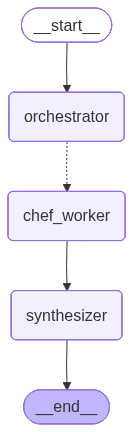

In [25]:
# display the orchestrator workflow using mermaid chart
display(Image(orchestrator_worker.get_graph().draw_mermaid_png()))

## Testing (Orchestration)

Finally, we'll test the workflow by invoking it with a sample meal request to see the end-to-end meal planning process in action:


In [26]:
# invoke the workflow with a string of meals in a dict
state = orchestrator_worker.invoke({"meals": "Steak and eggs, tacos, and chili"})

We can access the complete meal planning guide that contains all the detailed cooking instructions from our specialized chefs:


In [27]:
# print the first 2000 characters of our final_meal_guide
pprint(state["final_meal_guide"][:2000])

('Hello! My name is Chef Alex, and I am a passionate chef with a background in '
 'American cuisine. Over the years, I’ve honed my skills in various culinary '
 'techniques and have a deep appreciation for classic comfort foods. Today, '
 'I’m excited to share with you a delicious and hearty dish that’s perfect for '
 'breakfast, brunch, or even dinner: Steak and Eggs.\n'
 '\n'
 '### Ingredients:\n'
 '- 1 ribeye or sirloin steak (about 1 inch thick)\n'
 '- 2 large eggs\n'
 '- Salt (to taste)\n'
 '- Pepper (to taste)\n'
 '- 2 tablespoons of butter\n'
 '\n'
 '### Preparation Steps:\n'
 '1. **Prepare the Steak:**\n'
 '   - Remove the steak from the refrigerator and let it sit at room '
 'temperature for about 30 minutes. This helps it cook more evenly.\n'
 '   - Season both sides of the steak generously with salt and pepper.\n'
 '\n'
 '2. **Heat the Pan:**\n'
 '   - Preheat a cast-iron skillet or a heavy-bottomed frying pan over '
 'medium-high heat. Allow it to get hot, which will give t

# Reflection Pattern

The Reflection Pattern is where an AI agent **iteratively** evaluates and improves its own outputs through self-assessment and feedback loops, similar to reflective agents in cognitive science. Rather than providing a single recommendation, the system creates an initial proposal, critically evaluates it against established criteria, and then refines the output based on that evaluation. This cycle continues **until the system achieves an optimal solution** that meets predefined quality standards.

In this section, we'll build an intelligent investment advisory system that iteratively refines portfolio recommendations through continuous evaluation and feedback loops. The system combines aggressive growth strategies with conservative risk assessment to find the optimal balance for each investor's profile. The reflection pattern enables the system to self-correct and adapt its recommendations, ensuring each portfolio suggestion is thoroughly vetted before presentation to the investor.

<img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/9kH761sRFhuVPWzBUZhgkA/reflection.png" width="100%" alt="reflection">


## State (Reflection)

Similar to the previous workflow, we'll also be using a state to track variables and values across this workflow. The following `State` dictionary represents the evolving context in an **Investment Advice Evaluator-Optimizer workflow**, tracking the user's investment profile, their investment plan, feedback from the evaluator, the user's safety (or risk) profile, the target safety profile, and a counter `n` for iterations.


In [28]:
grades = Literal[
    "ultra-conservative", 
    "conservative", 
    "moderate", 
    "aggressive", 
    "high risk"
]

class State(TypedDict):
    investment_plan: str
    investor_profile: str
    target_grade: grades
    feedback: str
    grade: grades
    n: int = 0

- `investment_plan`: Our generated plan that will be evaluated and revised if need be
- `investor_profile`: The user inputted profile that we'll use as a reference for the plan
- `target_grade`: A generated ideal risk tolerance grade based on the investor profile
- `feedback`: Evaluator feedback for the investment plan
- `grade`: Evaluated grade of the investment plan
- `n`: Number of evaluation iterations

**Note:** Both grade fields are `Literal` meaning they can only take a value within the defined list.


## Setup Node

Before building our Generator and Evaluator nodes, let's create a node that determines a fitting `target_grade` based on the investor profile. This value will remain **static** throughout the evaluation workflow and exists to push the generated output towards a general direction.

We'll start by creating the prompt and the pipe to get the `target_grade`:


In [29]:
grade_prompt = ChatPromptTemplate.from_messages([
    ("system",
     "You are an investment advisor. Given the investor’s profile and their proposed plan,"
     "choose exactly one risk classification from: ultra-conservative, conservative, moderate, aggressive, high risk."
     "Return ONLY the grade."
    ),
    ("user",
     "Investor profile:\n\n{investor_profile}\n\n"
    )
])

grade_pipe = grade_prompt | llm

Using the pipe we can create a function (node) to return the dict with the ideal `target_grade` key:


In [30]:
def determine_target_grade(state: State):
    """Ask the LLM to pick the best-fitting target_grade."""
    response = grade_pipe.invoke({
        "investor_profile": state["investor_profile"]
    })
    
    # return as a plain dict so LangGraph can merge it into the state
    return {"target_grade": response.content.lower()}

Similar to the **orchestration workflow** we'll use a `dummy_state` to test our nodes. Let's initialize it with an example investor profile:


In [31]:
# initialize empty state except for the user inputted investor profile
dummy_state: State = {
    "investment_plan": "",
    "investor_profile": (
        "Age: 29\n"
        "Salary: $110,000\n"
        "Assets: $40,000\n"
        "Goal: Achieve financial independence by age 45\n"
        "Risk tolerance: High"
    ),
    "target_grade": "",
    "feedback": "",
    "grade": "",
    "n": 0
}

Using the function we can determine a target grade and update the dummy state:


In [32]:
# get target grade
target_grade = determine_target_grade(dummy_state)
# update target grade with the returned dict
dummy_state.update(target_grade)
pprint(dummy_state)

{'feedback': '',
 'grade': '',
 'investment_plan': '',
 'investor_profile': 'Age: 29\n'
                     'Salary: $110,000\n'
                     'Assets: $40,000\n'
                     'Goal: Achieve financial independence by age 45\n'
                     'Risk tolerance: High',
 'n': 0,
 'target_grade': 'aggressive'}


## Generator Node

The first step in the Reflection workflow is the **generator node**, which produces an investment plan based on an investor's profile. The generator node is responsible for producing an investment strategy based on the investor profile. However, instead of generating a single plan, we design a **multi-phase generator** that evolves through feedback: starting bold, then refining based on evaluation.

### Phase 1: Initial Generation

In this initial generated strategy, we simulate the style of **Cathie Wood**, a well-known investor who takes a venture-style approach: favoring high-growth, high-risk opportunities over conservative, value-based strategies.

To model this, we define:

- A **system message** that describes Cathie Wood's investment philosophy: bold, tech-focused, and speculative.
- A **user message** that provides the specific investor profile.
- A **chained LLM**, `cathie_wood_pipe`, which combines both messages into a structured generation pipeline.

This generator node serves as the **creative initiator** of the workflow, producing a candidate investment strategy that downstream nodes will later evaluate, critique, or refine:


In [33]:
# inital generation, no feedback, only based on profile
cathie_wood_prompt = ChatPromptTemplate.from_messages([
    ("system",
    """You are a bold, innovation-driven investment advisor inspired by Cathie Wood.

Your goal is to generate a high-conviction, forward-looking investment plan that embraces disruptive technologies,
emerging markets, and long-term growth potential. You are not afraid of short-term volatility as long as the upside is transformational.

Create an investment strategy tailored to the investor profile below. Prioritize innovation and high-reward opportunities,
such as artificial intelligence, biotechnology, blockchain, or renewable energy.

Respond with a concise investment plan in paragraph form.
"""
    ),
    ("human", "Investor profile:\n\n{investor_profile}")
])

cathie_wood_pipe = cathie_wood_prompt | llm

The second phase of the generator will require feedback from the evaluator, so let's format the evaluator's output for subsequent generation. After the initial plan is generated, an evaluator agent will analyze it and return a structured `Feedback` schema:


In [34]:
# evaluator output schema
class Feedback(BaseModel):
    grade: grades = Field(
        description="Classify the investment based on risk level, ranging from ultra-conservative to high risk."
    )
    feedback: str = Field(
        description="Provide reasoning for the risk classification assigned to the investment suggestion."
    )

### Phase 2: Adaptive Generation

To improve the initial plan, we introduce a second generator — this time inspired by **Ray Dalio**, a more conservative and macroeconomically grounded investor. This part takes the `Feedback` (`grade` and `feedback`) from the **evaluator** along with the `investor_profile` from the state. This is done via the **human message** as the LLM is imagining a conversation where it has received previous feedback.

To model this, we define:

- A **system message** that describes Ray Dalio's investment strategy: conservative.
- A **human message** that provides the specific investor profile and the feedback.
- A **chained LLM**, `ray_dalio_pipe`, which combines both messages into a structured generation pipeline.


In [35]:
ray_dalio_prompt = ChatPromptTemplate.from_messages([
    ("system",
    """You are an investment advisor inspired by Ray Dalio's principles but with adaptive strategy generation.
Your goal is to create varied, scenario-aware investment plans that respond dynamically to economic conditions,
feedback, and the investor's evolving needs. You adapt your recommendations based on previous evaluations.

CORE PRINCIPLES:
- Environmental diversification across economic regimes (growth/inflation combinations)
- Risk parity weighting by volatility, not just dollar amounts
- Inflation-aware asset selection with real return focus
- Macroeconomic scenario planning and regime identification

ADAPTATION RULES based on feedback:
- If deemed "too conservative" → Increase growth equity allocation, add emerging markets, consider alternatives
- If deemed "too aggressive" → Add defensive assets, increase bond allocation, focus on dividend stocks
- If "lacks inflation protection" → Emphasize TIPS, commodities, REITs, international exposure
- If "too complex" → Simplify to core ETF strategy with clear rationale
- If "insufficient diversification" → Add geographic, sector, or alternative asset exposure

ECONOMIC SCENARIO ADJUSTMENTS:
- Rising inflation environment → Emphasize commodities, TIPS, real estate, reduce duration
- Stagflation concerns → Focus on energy, materials, international markets, inflation hedges
- Deflationary risks → Increase government bonds, high-quality corporate bonds, cash positions
- Growth acceleration → Favor technology, consumer discretionary, small-cap growth
- Economic uncertainty → Balance with "All Weather" approach using multiple asset classes

TARGETING 15% RETURNS through:
- Strategic overweighting of growth assets during favorable conditions
- Tactical allocation adjustments based on economic regime
- Alternative investments (REITs, commodities, international) for diversification
- Leverage consideration for qualified investors
- Regular rebalancing to capture volatility

Respond with a clear, actionable investment plan that reflects current economic conditions 
and adapts to the specific feedback provided. Vary your approach significantly based on 
the grade and feedback received.
"""
    ),
    ("human",
     """Investor profile:
{investor_profile}

Previous strategy grade: {grade}

Evaluator feedback: {feedback}

Based on this feedback, create a NEW investment strategy that addresses the concerns raised 
while targeting 15% returns. Make significant adjustments from any previous approach.
""")
])

ray_dalio_pipe = ray_dalio_prompt | llm

### Build the Generator Node

The `investment_plan_generator` node serves as a dynamic strategy creator in our **Reflection workflow**. It adapts its behavior based on whether the system is generating an initial plan or refining a prior one based on feedback.

This generator switches between two distinct investment personas:

- **Cathie Wood–style (Initial Phase)**  
  If no prior feedback exists in the state, the generator uses `cathie_wood_pipe`, producing a high-growth, innovation-driven strategy that emphasizes disruptive technologies and bold returns.

- **Ray Dalio–style (Refinement Phase)**  
  If feedback from an evaluator is already present (`state["feedback"]`), the generator invokes `ray_dalio_pipe` to adapt the plan accordingly. It uses:
  - The original investor profile
  - The evaluator's risk grade (for example, "high risk")
  - Specific feedback (for example, "not diversified", "too aggressive")

This allows the workflow to **evolve investment strategies over time**, adjusting recommendations in response to critique — a key agentic reflection pattern:


In [36]:
def investment_plan_generator(state: State) -> dict:
    """Prompts an LLM to generate or improve an investment plan based on the current state."""

    if state.get("feedback"):
        # use Ray Dalio–style generator when feedback is available
        response = ray_dalio_pipe.invoke({
            "investor_profile": state["investor_profile"],
            "grade": state["grade"],
            "feedback": state["feedback"]
        })
    else:
        # use Cathie Wood–style generator for initial plan
        response = cathie_wood_pipe.invoke({
            "investor_profile": state["investor_profile"]
        })

    return {"investment_plan": response.content}

Now we can test the generator node with our `dummy_state`. Currently it only has the `investment_profile` and `target_grade` fields filled and the `feedback` field empty so it will go with the Cathie Wood-style investment plan generator. We can update the `dummy_state` variable with the new plan and print it out:


In [37]:
# get the investment plan
initial_investment_plan = investment_plan_generator(dummy_state)
# update the dummy state with generated plan
dummy_state.update(initial_investment_plan)
pprint(dummy_state)

{'feedback': '',
 'grade': '',
 'investment_plan': 'To achieve financial independence by age 45, your '
                    'investment strategy should focus on a diversified '
                    'portfolio that emphasizes high-growth sectors, '
                    'particularly in disruptive technologies and emerging '
                    'markets. With a strong risk tolerance and a time horizon '
                    'of 16 years, allocate approximately 40% of your portfolio '
                    'to artificial intelligence and machine learning '
                    'companies, such as leading innovators in autonomous '
                    'systems and data analytics. Next, invest 30% in '
                    'biotechnology firms that are pioneering breakthroughs in '
                    'gene editing and immunotherapies, as this sector is '
                    'poised for exponential growth in healthcare. Dedicate 20% '
                    'to renewable energy, specifically stocks i

## Evaluator Node

The Evaluator Node is responsible for critically assessing the investment strategy generated by the system. It does so through the lens of **Warren Buffett's value-investing philosophy**, which emphasizes:

- Capital preservation  
- Sound business fundamentals  
- Long-term stability  
- Caution toward speculative or high-volatility assets

This makes Buffett's conservative worldview the perfect counterbalance to the aggressive strategies generated by the Cathie Wood–style generator.

### What the Evaluator Does

The evaluator reviews the generated `investment_plan` in the context of the `investor_profile` and a predefined `target_grade`. It then:

- Assigns a risk **grade** (One of the predefined `Literal` values).
- Provides a concise **feedback explanation** justifying the grade.

The evaluation schema `Feedback` was defined earlier, it'll be used to defined the structured output for our `evaluator_prompt`:


In [38]:
# Warren Buffet style evaluation prompt
evaluator_prompt = ChatPromptTemplate.from_messages([
    ("system", 
    """You are an investment risk evaluator inspired by Warren Buffett's value investing philosophy.

Your task is to assess whether a proposed investment strategy aligns with conservative, value-driven principles 
that emphasize capital preservation, long-term stability, and sound business fundamentals. You should be 
skeptical of speculative investments, high-volatility assets, and short-term market trends.

RISK CLASSIFICATION LEVELS:
- ultra-conservative: Extremely safe, minimal risk of loss
- conservative: Low risk, prioritizes capital preservation  
- moderate: Balanced approach with acceptable risk-reward ratio
- aggressive: Higher risk for potentially greater returns
- high risk: Speculative investments with significant loss potential

EVALUATION CRITERIA:
- Business clarity: Is the investment easily understandable with transparent cash flows?
- Margin of safety: Does the investment price provide protection against downside risk?
- Capital preservation: Will this strategy protect wealth over the long term?
- Investor alignment: Does this match a conservative investor's risk tolerance and goals?
- Quality fundamentals: Are the underlying assets financially sound with competitive advantages?

Return your assessment in the following  format:
{{
  "grade": "<investment risk level>",
  "feedback": "<concise explanation of the assigned risk level and key reasoning>"
}}
"""
    ),
    ("human", 
     "Evaluate this investment plan:\n\n{investment_plan}\n\nFor this investor profile:\n\n{investor_profile}\n\nAnd provide feedback that matches this target risk level: {target_grade}")
])

# create the pipe with the structured output that outputs a Feedback object
buffett_evaluator_pipe = evaluator_prompt | llm.with_structured_output(Feedback)

### Build the Generator Node

The `evaluate_plan` node is responsible for reviewing the generated investment strategy and assigning it a risk grade and explanation. This is done using our **Buffett-inspired evaluator** pipeline, which applies value-investing principles to judge whether the proposed plan matches the investor's target risk profile.

This node:

- Takes the current `investment_plan` from the state
- Assesses it with regards to the `investor_profile` and your ideal `target_grade`
- Uses the `buffett_evaluator` to generate:
  - A structured **grade** (for example, `"moderate"`, `"aggressive"`)
  - A **feedback** string justifying the risk classification
- Increments a counter `n` to keep track of how many iterations (reflection loops) have occurred


In [39]:
def evaluate_plan(state: State):
    """LLM evaluates the investment plan"""

    # add one to the current count
    current_count = state.get('n', 0) + 1

    # get the evaluation result from the evaluator pipe
    evaluation_result = buffett_evaluator_pipe.invoke({
        "investment_plan": state["investment_plan"],
        "investor_profile": state["investor_profile"],
        "target_grade": state["target_grade"]
    })

    # return the grade and feedback in a dict
    return {"grade": evaluation_result.grade, "feedback": evaluation_result.feedback, "n": current_count}

Now we can test the evaluator node with our `dummy_state`. Pass the state into our `evaluate_plan` to evaluate the investment plan and update the state with the returned dictionary:


In [40]:
# get the feedback
evaluated_feedback = evaluate_plan(dummy_state)
# update the dummy state with the feedback
dummy_state.update(evaluated_feedback)

Now we can see the `feedback` and `grade` of our investment plan:


In [41]:
print(f"Grade: {dummy_state["grade"]}")
print(f"Feedback: {dummy_state["feedback"]}")

Grade: high risk
Feedback: The proposed investment plan is heavily focused on high-growth sectors such as artificial intelligence, biotechnology, renewable energy, and blockchain technology. While these sectors offer potential for substantial returns, they also come with significant volatility and speculative risks. The concentration in disruptive technologies indicates a lack of diversification that aligns with conservative principles. Additionally, the focus on emerging markets and high-growth industries increases exposure to market fluctuations and uncertainty, which does not prioritize capital preservation or sound business fundamentals. Therefore, this strategy is classified as high risk due to its speculative nature and potential for significant loss.


## Routing Node

The `route_investment` node acts as a **decision-making mechanism** in our LangGraph workflow. After a strategy is evaluated, this node determines whether to:

- Accept the current investment plan and end the loop.
- Send it back to the generator for refinement.
- Stop the process entirely after too many failed attempts.

---

### How It Works

The router checks two key fields from the shared `state`:

1. `grade`: Assigned by the evaluator
2. `target_grade`: The prefferred risk classification from the investor profile

It also checks the **iteration count** `n`, which tracks how many times the strategy has been revised:


In [42]:
def route_investment(state: State, iteration_limit: int = 5):
    """Route investment based on risk grade evaluation"""
    # get grades
    current_grade = state.get("grade", "MISSING")
    target_grade = state.get("target_grade", "MISSING")
    # check if grades match
    match = current_grade == target_grade

    # print out the tracked values
    print(f"=== ROUTING  ===")
    print(f"Current grade: '{current_grade}'")
    print(f"Target risk profile: '{target_grade}'")
    print(f"Match: {match}")
    print(f"Number of trials: {state['n']}")

    # routing logic
    if match: # grades match
        print("→ Routing to: Accepted")
        return "Accepted"
    elif state['n'] > iteration_limit: # review iterations exceeds limit
        print("→ Too many iterations, stopping")
        return "Accepted"
    else: # grades don't match
        print("→ Routing to: Rejected + Feedback")
        return "Rejected + Feedback"

## Building the Workflow (Reflection)

To enable iterative refinement of investment strategies, we construct a **Reflection Workflow** using `StateGraph`. This workflow mimics how a thoughtful advisor might revise and re-evaluate strategies over multiple rounds based on feedback.

---

### Core Idea

The reflection pattern involves a **loop** between generation and evaluation:

1. Generate a strategy based on the investor profile and risk appetite
2. Evaluate the strategy using structured feedback
3. If the strategy doesn't match the target grade, revise and repeat

This cycle allows the system to **improve** and **adapt** the investment plan through reflection — not just respond once.

---

### Building

1. **Add Core Nodes**
   - `determine_target_grade`: Determines the appropriate target risk level based on the investor profile.
   - `investment_plan_generator`: Generates an investment plan using an LLM in the style of Cathie Wood or Ray Dalio.
   - `evaluate_plan`: Evaluates the generated plan using a Buffett-inspired risk assessment model.
2. **Define the Workflow Edges**
   - Connect `START → determine_target_grade`
   - Connect `determine_target_grade → investment_plan_generator`
   - Connect `investment_plan_generator → evaluate_plan`
3. **Establish Core Flow**
   - The generator and evaluator form the backbone of the reflection loop.
   - This flow ensures that every strategy is generated and evaluated before further routing decisions are made.
4. Add a **conditional Routing Node** to:
   - Compare the evaluated grade to the target grade.
   - Decide whether to accept the strategy or route it back for refinement.


In [43]:
# initialize StateGraph with the given State schema
optimizer_builder = StateGraph(State)

# add the setup, generator, and evaluator nodes
optimizer_builder.add_node("determine_target_grade", determine_target_grade)
optimizer_builder.add_node("investment_plan_generator", investment_plan_generator)
optimizer_builder.add_node("evaluate_plan", evaluate_plan)

# define the flow with edges
optimizer_builder.add_edge(START, "determine_target_grade")
optimizer_builder.add_edge("determine_target_grade", "investment_plan_generator")
optimizer_builder.add_edge("investment_plan_generator", "evaluate_plan")

### Conditional Routing

To enable iterative refinement, we complete the reflection loop by adding a **conditional edge** from the evaluator node. This edge dynamically routes the workflow based on the evaluation outcome. The conditional edge uses a `lambda` function to invoke the `route_investment` decision logic. This logic compares the evaluator's assigned risk grade against the target risk profile, and checks how many iterations have already occurred.

Depending on the result:

- If the plan is **Accepted** (as in, the grade matches the target), the workflow proceeds to `END`.
- If the plan is **Rejected + Feedback**, it loops back to the generator for refinement.
- If the maximum number of iterations (for example, 5) is reached, the loop exits gracefully with the last attempt.


In [44]:
# add conditional edge for reflection
optimizer_builder.add_conditional_edges(
    "evaluate_plan",
    lambda state: route_investment(state),
    {
        "Accepted": END,
        "Rejected + Feedback": "investment_plan_generator",
    },
)

Finally we'll compile our builder into a workflow that can take an investment profile and iteratively generate an investment plan for it:


In [45]:
# compile the workflow
optimizer_workflow = optimizer_builder.compile()

### Visualization

Again, we'll use LangGraph's built in Mermaid charts to visualize the graph:


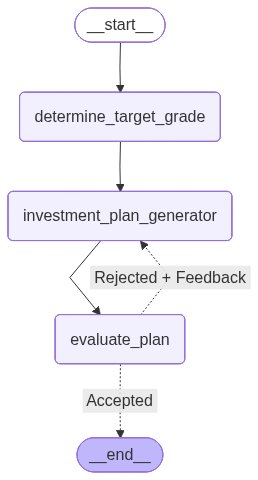

In [46]:
# display the graph
display(Image(optimizer_workflow.get_graph().draw_mermaid_png()))

## Testing (Reflection)

Finally, we'll test the workflow by invoking it with an example investment profile to see the end-to-end investment plan generation process in action:


In [47]:
# invoke the workflow with an example investor profile
state = optimizer_workflow.invoke({
    "investor_profile": (
        "Age: 29\n"
        "Salary: $110,000\n"
        "Assets: $40,000\n"
        "Goal: Achieve financial independence by age 45\n"
        "Risk tolerance: High"
    )
})

=== ROUTING  ===
Current grade: 'high risk'
Target risk profile: 'aggressive'
Match: False
Number of trials: 1
→ Routing to: Rejected + Feedback
=== ROUTING  ===
Current grade: 'moderate'
Target risk profile: 'aggressive'
Match: False
Number of trials: 2
→ Routing to: Rejected + Feedback
=== ROUTING  ===
Current grade: 'moderate'
Target risk profile: 'aggressive'
Match: False
Number of trials: 3
→ Routing to: Rejected + Feedback
=== ROUTING  ===
Current grade: 'moderate'
Target risk profile: 'aggressive'
Match: False
Number of trials: 4
→ Routing to: Rejected + Feedback
=== ROUTING  ===
Current grade: 'aggressive'
Target risk profile: 'aggressive'
Match: True
Number of trials: 5
→ Routing to: Accepted


We can view the final returned state of the workflow below:


In [48]:
def pretty_print_final_state(state: dict):
    print("🎯 Final Investment Plan Summary\n" + "="*40)
    print(f"\n📌 Investor Profile:\n{state['investor_profile']}")
    
    print("\n📈 Target Risk Grade:", state['target_grade'])
    print("📊 Final Assigned Grade:", state['grade'])
    print("🔁 Iterations Taken:", state['n'])

    print("\n📝 Evaluator Feedback:\n" + "-"*30)
    print(state['feedback'])

    print("\n📃 Final Investment Plan:\n" + "-"*30)
    print(state['investment_plan'])

pretty_print_final_state(state)

🎯 Final Investment Plan Summary

📌 Investor Profile:
Age: 29
Salary: $110,000
Assets: $40,000
Goal: Achieve financial independence by age 45
Risk tolerance: High

📈 Target Risk Grade: aggressive
📊 Final Assigned Grade: aggressive
🔁 Iterations Taken: 5

📝 Evaluator Feedback:
------------------------------
This investment strategy aims for a high target return of 15% and includes a significant allocation (60%) to equities, particularly high-growth sectors. While there are elements of risk management and some capital preservation through fixed income and inflation-protection assets, the overall reliance on growth equities, emerging markets, and alternative investments like cryptocurrency indicates a higher risk profile. The inclusion of hedge funds and private equity also adds speculative elements. This plan aligns with the investor's high-risk tolerance but carries substantial volatility and potential for significant loss, classifying it as aggressive.

📃 Final Investment Plan:
---------

# Conclusion

In this lab, we’ve explored how **LangGraph** empowers you to build dynamic, agentic AI workflows. 

Throughout, we learned and applied important concepts such as:

1. **Orchestrator–Worker Pattern**  
   - High-level planning with an orchestrator node  
   - Parallel task execution by independent worker nodes  
   - Automatic state merging via `Annotated` fields

2. **Reflection Pattern**  
   - Iterative generate–evaluate loops inspired by real investor personas  
   - Structured feedback using Pydantic output parsers  
   - Conditional routing to refine or accept results until they meet targets

3. **State Management & Routing**  
   - A shared `State` schema carrying context across nodes  
   - Flexible fan-out and conditional edges (`Send`, `add_conditional_edges`)  
   - Loop control via iteration counters and routing logic

4. **Visualization & Testing**  
   - Mermaid diagrams for graph structure inspection  
   - Manual simulations and pretty-print utilities for debugging and presentation

---

## Next Steps

- **Check out [Watsonx Orchestrate](https://www.ibm.com/products/watsonx-orchestrate?utm_source=skills_network&utm_content=in_lab_content_link&utm_id=Lab-Agentic+Design+Patterns+in+LangGraph-v1_1752612018)**: AI Agents for business to automate and handle simple tasks using orchestration.
- **Extend the Patterns**: Try the optimizer (plan–evaluate) pattern or combine reflection with reinforcement learning.
- **Domain Adaptation**: Swap out the grocery-list or investment example for customer support, legal drafting, or robotic control.
- **Monitoring & Metrics**: Instrument your graph with logging, latency tracking, and success/failure metrics.
- **Error Handling & Robustness**: Add retry policies, fallback nodes, and alerting for production readiness.

By mastering these design patterns—**orchestration**, **evaluation**, **reflection**, and **routing**—you can create truly **agentic systems** that plan, critique, adapt, and improve over time. 

#### Happy building!


## Authors

[Joseph Santarcangelo](https://author.skills.network/instructors/joseph_santarcangelo) | Data Scientist @ IBM <br>
[Wojciech "Victor" Fulmyk](https://author.skills.network/instructors/wojciech_fulmyk) | Data Scientist @ IBM <br>
[Kunal Makwana](https://author.skills.network/instructors/kunal_makwana) | AI Software Developer @ IBM<br>
[Joshua Zhou](https://author.skills.network/instructors/joshua_zhou) | Data Scientist Intern @ IBM


## Change Log

<details>
    <summary>Click here for the changelog</summary>

|Date (YYYY-MM-DD)|Version|Changed By|Change Description|
|-|-|-|-|
|2025-06-25|0.1|Joseph|Initial version created|
|2025-07-11|1.0|Joshua|First completed draft|
|2025-07-22|1.1|Steve Ryan|ID review|
|2025-07-22|1.2|Leah Hanson|QA review|

</details>

---



Copyright © IBM Corporation. All rights reserved.
